# Trabajo Práctico 2: Reseñas de Películas - Pruebas de preprocesamiento, Random Forests y ensambles.

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

# Librerias y dependencias

In [1]:
!pip install nltk
!python -m spacy download es_core_news_sm
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 32.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')

import spacy

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

import joblib

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_text

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from unidecode import unidecode

from sklearn import metrics

# Constants
SEED = 13

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Modelos exportados

Carga de los modelos con los mejores hiperparámetros encontrados a lo largo de la notebook.

In [5]:
ensemble = joblib.load("gb_rf_kn_ensemble.pkl")
rf = joblib.load("rf300iter.pkl")
gb = joblib.load("gb300iter.pkl")
kn = joblib.load("kn.pkl")
ab = joblib.load("ab10iter.pkl")

Split de train/test de los CSVs ya preprocesados con esta notebook.

In [6]:
# Lematized datasets.
df_train = pd.read_csv("lemmatized_train.csv", encoding='utf-8', on_bad_lines='warn')
df_test = pd.read_csv("lemmatized_test.csv", index_col=0)

X_train, X_test, y_train, y_test = train_test_split(df_train.review_es, df_train.sentimiento, test_size=0.2, random_state=SEED, stratify=df_train.sentimiento)

# Preprocesamiento

Listado de posibles tareas a realizar:
- Remover mayúsculas.
- Remover tildes y signos ortográficos.
- Remover las reviews en inglés.
- Aplicar lemmatización con `spacy`
- Aplicar stemming con `nltk` (quizás es preferible simplemente usar lemmatización según recomendaciones de las clases prácticas)
- Remover stop words.

Cargo los CSV de training y de testing.

In [ ]:
df_train = pd.read_csv("train.csv", encoding='utf-8', on_bad_lines='warn')

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8599 entries, 60000 to 68598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_es  8599 non-null   object
 1   reviews    8599 non-null   object
dtypes: object(2)
memory usage: 201.5+ KB


In [ ]:
df_train = pd.read_csv("train.csv", encoding='utf-8', on_bad_lines='warn')
df_test = pd.read_csv("test.csv", index_col=0)
df_train.columns

Creo el lematizador usando la librería `spacy`.

In [ ]:
nlp = spacy.load('es_core_news_sm')

def lemmatizer(text):
  sent = []
  doc = nlp(text)
  for word in doc:
    sent.append(word.lemma_)
  return " ".join(sent)

Aplico lematización a los sets de training y test.

In [ ]:
# Lemmatize test
df_test["review_es"] = df_test.apply(lambda x: lemmatizer(x['review_es']), axis=1)

In [ ]:
df_train_copy2 = df_train.copy()
df_train_copy2["review_es"] = df_train_copy2.apply(lambda x: lemmatizer(x['review_es']), axis=1)

In [ ]:
df_lemmatized_copy = df_train_copy2.copy()

In [ ]:
df_train_copy2

,ID,review_es,sentimiento
0,0,uno de el otro critico haber mencionar que des...,positivo
1,1,uno pequeno pequeno produccion el tecnica de...,positivo
2,2,pensar que este ser uno manera maravilloso de ...,positivo
3,3,basicamente haber uno familia donde uno nino...,negativo
4,4,el amor en el tiempo de petter mattei ser ...,positivo
...,...,...,...
49995,49995,pensar que este pelicula hacer uno buen trabaj...,positivo
49996,49996,mala parcela mal dialogo malo actuacion ...,negativo
49997,49997,ser catolico ensenado en escuela primario parr...,negativo
49998,49998,ir a tener que estar en desacuerdo con el come...,negativo


Creo una función de preprocesamiento para remover signos diacríticos, mayúsculas, números y símbolos.

In [8]:
def preprocess(
  text: str,
  lower: bool = True,
  remove_diacritics: bool = True,
  remove_symbols: bool = True,
  remove_numbers: bool = True
) -> str:
  if lower:
    text = text.lower()

  # Remove diacritics with the Unicode library.
  if remove_diacritics:
    text = unidecode(text)

  if remove_numbers:
    text = re.sub('[0-9]', '', text)

  # Replace every character that's not a letter or a number with a space.
  if remove_symbols:
    text = re.sub('[^a-zA-Z0-9ñÑÁÉÍÓÚáéíóúÜü]', ' ', text)

  text = text.strip()

  return text

In [ ]:
df_train_copy1 = df_train.copy()
df_train_copy1["review_es"] = df_train_copy1["review_es"].apply(preprocess, args=(True, True, True, True))

df_train_copy2["review_es"] = df_train_copy2["review_es"].apply(preprocess, args=(True, True, True, True))
df_test["review_es"] = df_test["review_es"].apply(preprocess, args=(True, True, True, True))

In [ ]:
df_train_copy2.to_csv("lemmatized_train.csv")
df_test.to_csv("lemmatized_test.csv")

## Vectorización



Uso un vectorizador TF-IDF para poder crear las matrices que serán usadas para los modelos. Cabe destacar que los parámetros max_df y min_df tuvieron poco impacto sobre el resultado de los modelos entrenados posteriormente (porque el vectorizador TF-IDF ya maneja bien las palabras más y menos frecuentes), pero si ayudaron a reducir notablemente el tiempo de entrenamiento.

In [9]:
stop_words = stopwords.words("spanish")
stop_words_tokenized = []
for w in stop_words:
    stop_words_tokenized = stop_words_tokenized + nltk.word_tokenize(preprocess(w))

In [10]:
vectorizer = TfidfVectorizer(
    preprocessor=preprocess,
    tokenizer=nltk.word_tokenize,
    token_pattern=None,
    max_df=0.7, # We could treat this one as a hyperparameter. It defines a threshold with which to ignore frequent words (corpus stop-words).
    min_df=0.01, # We could treat this one as a hyperparameter. It defines a threshold with which to ignore infrequent words.
    stop_words=stop_words_tokenized
)

In [11]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
X_train_vectorized

<40000x1573 sparse matrix of type '<class 'numpy.float64'>'
	with 2443284 stored elements in Compressed Sparse Row format>

## Random Forest

In [ ]:
base_classifier = RandomForestClassifier(random_state=SEED)

max_depth = list(range(1,6))
max_depth.append(None)

folds=5
params_search = {
    'n_estimators': list(range(20, 101)),
    'criterion': ['gini','entropy','log_loss'],
    'max_depth': max_depth,
    'min_samples_split': [0.2, 0.4, 0.6, 0.8],
    'max_features': ['sqrt', 'log2', 10, 15]
}

kfoldcv = StratifiedKFold(n_splits=folds)


scorer_fn = metrics.make_scorer(metrics.f1_score, labels=['negativo', 'positivo'], pos_label='positivo')
randomcv = RandomizedSearchCV(
    estimator=base_classifier,
    param_distributions = params_search,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter=300
)

randomcv.fit(X_train_vectorized, y_train)

best_classifier = randomcv.best_estimator_

joblib.dump(best_classifier, 'rf300iter.pkl', compress=9)

['rf300iter.pkl']

In [ ]:
best_classifier.fit(X_train_vectorized, y_train)
y_pred = best_classifier.predict(X_test_vectorized)

              precision    recall  f1-score   support

    negativo       0.84      0.82      0.83      5000
    positivo       0.82      0.84      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

F1-Score: 0.8293815459080054
Accuracy: 0.8294
Precision: 0.8295425732989121
Recall: 0.8293999999999999


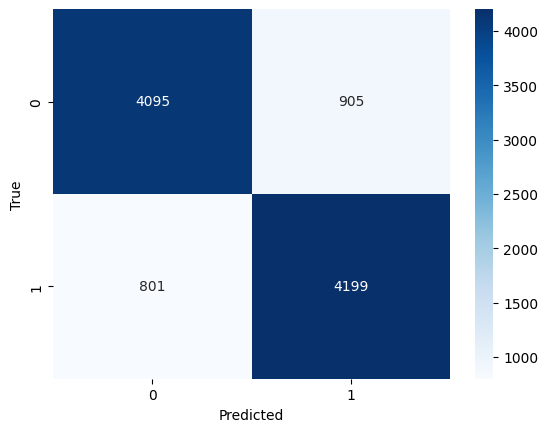

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

# Resultados con set de test para subir a Kaggle

In [ ]:
df_test["reviews"] = df_test["review_es"].apply(preprocess)
X_test_test = vectorizer.transform(df_test.reviews)
y_pred_test_rf_base = best_classifier.predict(X_test_test)
df_export = df_test.copy()
df_export["sentimiento"] = y_pred_test_rf_base
df_export.drop(["reviews"], axis="columns", inplace=True)
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export

df_export.to_csv("random_forest_with_random_search_stop_words_tfidf_vectorizer_lemmatized.csv")

# Ensamble

### Gradient Boosting

In [ ]:
base_classifier_gradient = GradientBoostingClassifier(random_state=SEED)

max_depth = list(range(1,6))

folds=5
params_search = {
    'n_estimators': list(range(100, 200)),
    'loss': ['log_loss', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error'],
    'learning_rate': [0.1, 0.5, 1.5],
    'max_depth': max_depth,
    'max_features': ['sqrt', 'log2', 10, 15]
}

kfoldcv = StratifiedKFold(n_splits=folds)


scorer_fn = metrics.make_scorer(metrics.f1_score, labels=['negativo', 'positivo'], pos_label='positivo')
randomcv_gradient = RandomizedSearchCV(
    estimator=base_classifier_gradient,
    param_distributions = params_search,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter=300
)

randomcv_gradient.fit(X_train_vectorized, y_train)

best_classifier_gradient = randomcv_gradient.best_estimator_

In [ ]:
joblib.dump(best_classifier_gradient, 'gb300iter.pkl', compress=9)

['gb300iter.pkl']

              precision    recall  f1-score   support

    negativo       0.85      0.84      0.85      5000
    positivo       0.84      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

F1-Score: 0.8467852852587963
Accuracy: 0.8468
Precision: 0.8469332778880334
Recall: 0.8468


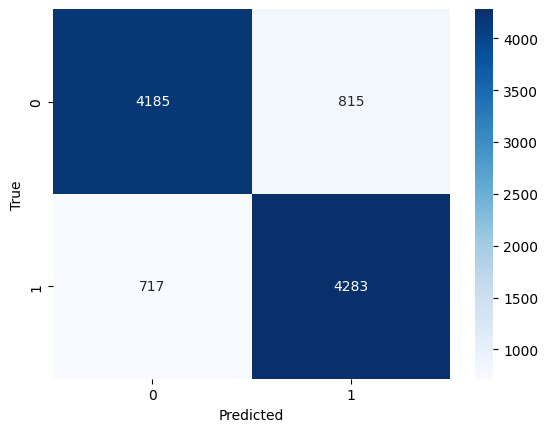

In [ ]:
y_pred = best_classifier_gradient.predict(X_test_vectorized)

sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

### Ada Boost

Se intentó entrenar un Ada Boost. Pero dado los altos tiempos de entrenamiento, no se pudo probar con una cantidad de iteraciones razonable, dando un modelo con mala performance.

In [ ]:
base_classifier_ad = AdaBoostClassifier(random_state=SEED)


folds=5
params_search = {
    'n_estimators': list(range(40, 100)),
    'learning_rate': [0.1, 0.5, 1.0, 1.5],
}

kfoldcv = StratifiedKFold(n_splits=folds)


scorer_fn = metrics.make_scorer(metrics.f1_score, labels=['negativo', 'positivo'], pos_label='positivo')
randomcv = RandomizedSearchCV(
    estimator=base_classifier_ad,
    param_distributions = params_search,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter=10
)

randomcv.fit(X_train_vectorized, y_train)

best_classifier_ab = randomcv.best_estimator_

In [ ]:
joblib.dump(best_classifier_ab, 'ab10iter.pkl', compress=9)

['ab10iter.pkl']

In [ ]:
best_classifier_ab

AdaBoostClassifier(learning_rate=0.5, n_estimators=97, random_state=13)

In [ ]:
best_classifier_ab = AdaBoostClassifier(random_state=SEED, n_estimators=300, learning_rate=0.05)
best_classifier_ab.fit(X_train_vectorized, y_train)

AdaBoostClassifier(learning_rate=0.05, n_estimators=300, random_state=13)

              precision    recall  f1-score   support

    negativo       0.83      0.77      0.80      5000
    positivo       0.79      0.84      0.81      5000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

F1-Score: 0.8068806763152845
Accuracy: 0.8071
Precision: 0.8085014480380894
Recall: 0.8070999999999999


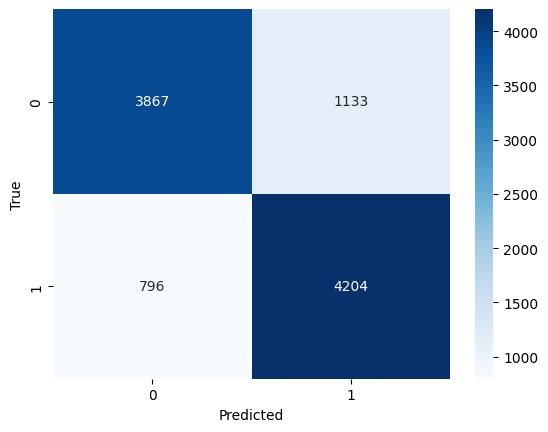

In [ ]:
y_pred = best_classifier_ab.predict(X_test_vectorized)

sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

### K Neighbours

Sucedió con este modelo lo mismo que con el de Ada Boost. No se pudo probar con una buena cantidad de iteraciones.

In [ ]:
base_classifier_kn = KNeighborsClassifier(n_jobs=-1)


folds=5
params_search = {
    'n_neighbors': [5],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

kfoldcv = StratifiedKFold(n_splits=folds)

scorer_fn = metrics.make_scorer(metrics.f1_score, labels=['negativo', 'positivo'], pos_label='positivo')
randomcv = RandomizedSearchCV(
    estimator=base_classifier_kn,
    param_distributions = params_search,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter=1
)

randomcv.fit(X_train_vectorized, y_train)

best_classifier_kn = randomcv.best_estimator_

### Ensamble final

In [12]:
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('kn', kn), ('ab', ab)],
    voting='hard')

In [13]:
ensemble.fit(X_train_vectorized, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_features='log2',
                                                     min_samples_split=0.2,
                                                     n_estimators=79,
                                                     random_state=13)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.5,
                                                         loss='exponential',
                                                         max_depth=5,
                                                         max_features='sqrt',
                                                         n_estimators=197,
                                                         random_state=13)),
                             ('kn',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_jobs=-1)),
                             ('ab',
                              AdaBoostClassifier(learning_rate=0.5,
                                                 n_estimators=97,
                                                 random_state=13))])

              precision    recall  f1-score   support

    negativo       0.83      0.85      0.84      5000
    positivo       0.84      0.82      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

F1-Score: 0.834576966496815
Accuracy: 0.8346
Precision: 0.8347864626682477
Recall: 0.8346


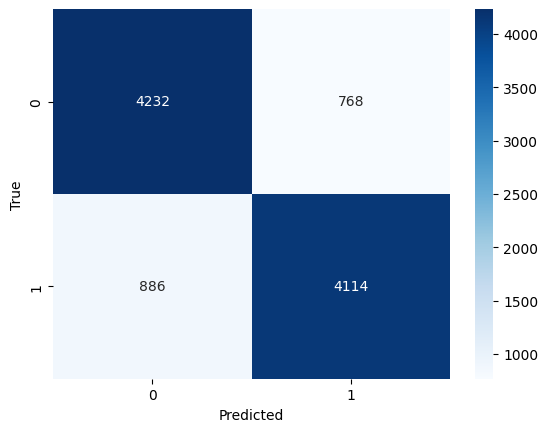

In [14]:
y_pred = ensemble.predict(X_test_vectorized)

sns.heatmap(confusion_matrix(y_test, y_pred), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average='macro', zero_division=0)))

In [15]:
joblib.dump(ensemble, 'gb_rf_kn_ab_ensemble.pkl', compress=9)

['gb_rf_kn_ab_ensemble.pkl']

In [ ]:
df_test["reviews"] = df_test["review_es"].apply(preprocess)
X_test_test = vectorizer.transform(df_test.reviews)
y_pred_test = ensemble.predict(X_test_test)

df_export = df_test.copy()
df_export["sentimiento"] = y_pred_test
df_export.drop(["reviews"], axis="columns", inplace=True)
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export

df_export.to_csv("voting_random_forest_gradient_boosting_k_neighbors_ada_boost_stop_words_tfidf_vectorizer_lemmatized.csv")

# Pruebas finales con los modelos entrenados sobre los datasets de train y de test

In [ ]:
df_test["reviews"] = df_test["review_es"].apply(preprocess)
rf.fit(X_train_vectorized, y_train)
X_test_test = vectorizer.transform(df_test.reviews)
y_pred_test = rf.predict(X_test_test)

df_export = df_test.copy()
df_export["sentimiento"] = y_pred_test
df_export.drop(["reviews"], axis="columns", inplace=True)
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export

df_export.to_csv("random_forest_300_iterations_random_search.csv")

---

              precision    recall  f1-score   support

    negativo       0.85      0.79      0.82     20000
    positivo       0.81      0.86      0.83     20000

    accuracy                           0.83     40000
   macro avg       0.83      0.83      0.83     40000
weighted avg       0.83      0.83      0.83     40000

F1-Score: 0.8278843115038041
Accuracy: 0.8281
Precision: 0.8297529327407738
Recall: 0.8281000000000001


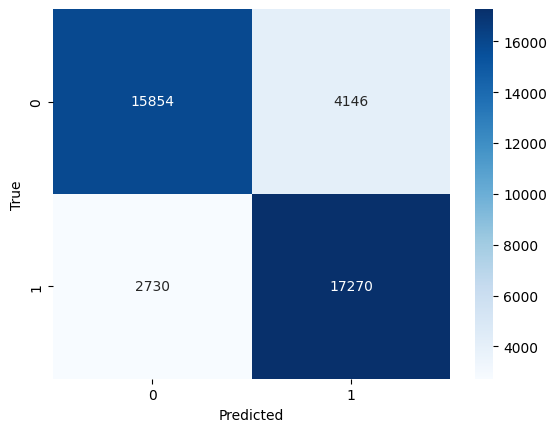

In [ ]:
rf.fit(X_train_vectorized, y_train)
y_pred_training = rf.predict(X_train_vectorized)

sns.heatmap(confusion_matrix(y_train, y_pred_training), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_train, y_pred_training, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_train, y_pred_training, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_train, y_pred_training)))
print('Precision: {}'.format(metrics.precision_score(y_train, y_pred_training, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_train, y_pred_training, average='macro', zero_division=0)))

              precision    recall  f1-score   support

    negativo       0.84      0.79      0.81      5000
    positivo       0.80      0.85      0.83      5000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

F1-Score: 0.8201434798633511
Accuracy: 0.8203
Precision: 0.8214188590483473
Recall: 0.8203


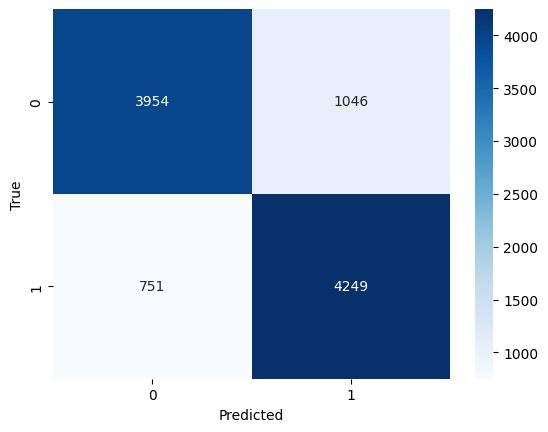

In [ ]:
#rf.fit(X_train_vectorized, y_train)
y_pred_test = rf.predict(X_test_vectorized)

sns.heatmap(confusion_matrix(y_test, y_pred_test), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred_test, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred_test, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred_test, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred_test, average='macro', zero_division=0)))

In [ ]:
rf

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_split=0.2, n_estimators=79, random_state=13)

In [ ]:
df_test["reviews"] = df_test["review_es"].apply(preprocess)
X_test_test = vectorizer.transform(df_test.reviews)
y_pred_test_rf = rf.predict(X_test_test)
df_export = df_test.copy()
df_export["sentimiento"] = y_pred_test_rf
df_export.drop(["reviews"], axis="columns", inplace=True)
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export

df_export.to_csv("random_forest_entropy_log2_min_samples_split02_n_stimators79.csv")

              precision    recall  f1-score   support

    negativo       0.91      0.90      0.91     20000
    positivo       0.90      0.92      0.91     20000

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000

F1-Score: 0.9058671619704085
Accuracy: 0.905875
Precision: 0.9060102267811574
Recall: 0.905875


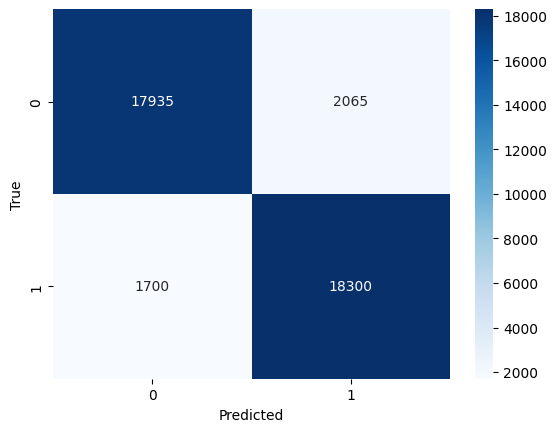

In [ ]:
gb.fit(X_train_vectorized, y_train)
y_pred_training = gb.predict(X_train_vectorized)

sns.heatmap(confusion_matrix(y_train, y_pred_training), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_train, y_pred_training, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_train, y_pred_training, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_train, y_pred_training)))
print('Precision: {}'.format(metrics.precision_score(y_train, y_pred_training, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_train, y_pred_training, average='macro', zero_division=0)))

              precision    recall  f1-score   support

    negativo       0.85      0.83      0.84      5000
    positivo       0.83      0.86      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

F1-Score: 0.8411679731100979
Accuracy: 0.8412
Precision: 0.84147542041509
Recall: 0.8412


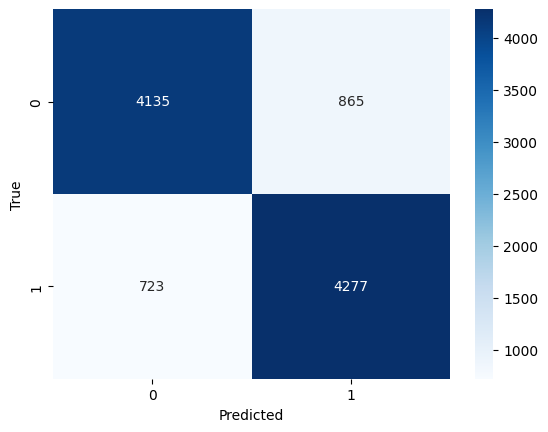

In [ ]:
#rf.fit(X_train_vectorized, y_train)
y_pred_test = gb.predict(X_test_vectorized)

sns.heatmap(confusion_matrix(y_test, y_pred_test), cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

print(metrics.classification_report(y_test, y_pred_test, zero_division=0))
print('F1-Score: {}'.format(metrics.f1_score(y_test, y_pred_test, average='macro')))
print('Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred_test)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred_test, average='macro', zero_division=0)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred_test, average='macro', zero_division=0)))

In [ ]:
gb

GradientBoostingClassifier(learning_rate=0.5, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=197,
                           random_state=13)

In [ ]:
df_test["reviews"] = df_test["review_es"].apply(preprocess)
X_test_test = vectorizer.transform(df_test.reviews)
y_pred_test_gb = gb.predict(X_test_test)
df_export = df_test.copy()
df_export["sentimiento"] = y_pred_test_gb
df_export.drop(["reviews"], axis="columns", inplace=True)
df_export.drop(["review_es"], axis="columns", inplace=True)
df_export

df_export.to_csv("gradient_boosting_learning_rate05_exponential_depth5_sqrt_197estimators.csv")